# State Space Reconstruction

In this example we will see how a Reservoir can reconstruct the trajectory in the phase space of a dynamical system. 
More specifically, we will see that when feeded with just one of the time series in the system, the Reservoir states can reproduce the dynamics of all the other variables.

Since the Reservoir is high-dimensional, we will use PCA to match the size of the Reservoir with that of the dynamical system.

In [55]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Local imports
from reservoir_computing.utils import make_forecasting_dataset
from reservoir_computing.reservoir import Reservoir

## Define the system

For this example, we will focus on the famous Lorenz system. 
The system is non-linear and has 3 dimensions, i.e., it is governed by 3 variables `x`, `y`, and `z` that evolve according to a system of three partial differential equations (PDEs):

\begin{cases}
    \frac{dx}{dt} &= \sigma (y(t) - x(t))\\
    \frac{dy}{dt} &= x(t) (\rho - z(t)) - y(t)\\
    \frac{dz}{dt} &= x(t)*y(t) - \beta z(t)
\end{cases}

The trajectory of the system is defined by the evolution of the state variables, defined by the time series $x(t)$, $y(t)$, and $z(t)$.
To obtain the time series, we first define the PDEs and then we integrate them over time using the `solve_ivp` function.

To visualize the attractor of the system, we simply have plot the three time series.

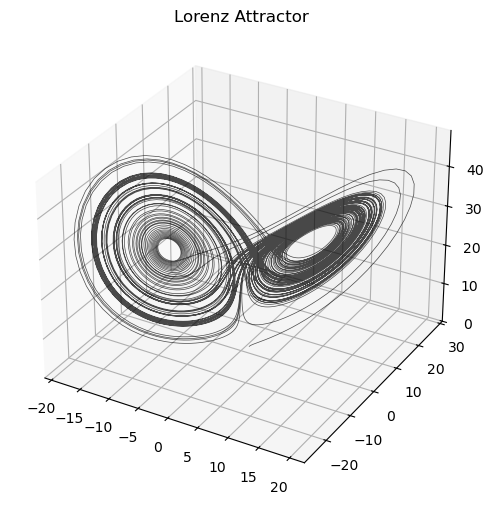

In [56]:
# Define the Lorenz system of equations
def lorenz_system(t, y, sigma, rho, beta):
    x, y, z = y
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

sigma, rho, beta = 10, 28, 8/3                      # Parameters of the system
y0 = [1.0, 1.0, 1.0]                                # Initial conditions
t_span = [0, 100]                                   # Time span for the integration
t = np.linspace(t_span[0], t_span[1], int(1e4))     # Time steps 

# Solve the differential equations
solution = solve_ivp(lorenz_system, t_span, y0, args=(sigma, rho, beta), t_eval=t)
x, y, z = solution.y[0], solution.y[1], solution.y[2]

# Plot the Lorenz attractor
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, 'k', linewidth=0.5, alpha=.7)
ax.set_title("Lorenz Attractor")
plt.show()

💡 Note that rather than generating the time series of the system from scratch we could have loaded the data using the `SynthLoader` function from `reservoir_computing.datasets`:

```python
x = SynthLoader().get_data('Lorenz')
```

## Train a Reservoir predictor

Let say we want to predict one of the three variables of the Lorenz system, e.g., `x`.
We will train a standard Reservoir-based predictor that produces a forecast $\boldsymbol{x}(t+h)$ from the current state $\boldsymbol{h}(t)$, where $h$ is the forecast horizon.

We use the utility function `make_forecasting_dataset` to split the time series in training and test data, each set composed of the input `X`, e.g., $\boldsymbol{x}(t)$ and the target values `Y`, e.g., $\boldsymbol{x}(t+h)$.

In [57]:
Xtr, Ytr, Xte, Yte, scaler = make_forecasting_dataset(
    x[:,None], 
    horizon=5,
    test_percent = 0.1)
print(f"Xtr shape: {Xtr.shape}\nYtr shape: {Ytr.shape}\nXte shape: {Xte.shape}\nYte shape: {Yte.shape}")

Xtr shape: (8995, 2)
Ytr shape: (8995, 1)
Xte shape: (995, 2)
Yte shape: (995, 1)


Next, we initialize the Reservoir and compute the Reservoir states associated with the training and test data.

In [58]:
# Initialize the Reservoir
res= Reservoir(
    n_internal_units=900,
    spectral_radius=0.99,
    input_scaling=0.1,
    connectivity=0.25)

n_drop=10 # Drop the first states due to the transient phase
states_tr = res.get_states(Xtr[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(Xte[None,:,:], n_drop=n_drop, bidir=False)
print(f"states_tr shape: {states_tr.shape}\nstates_te shape: {states_te.shape}")

states_tr shape: (1, 8985, 900)
states_te shape: (1, 985, 900)


The states of the Reservoir are usually high-dimensional. In this case, they are vectors of size `900`.
To reduce the dimensionality we apply PCA. Usually, this provides a form of regularization, since we need to use a readout with less parameters.
In this case, we also want to match the size of the Reservoir with the size of the Lorenz system, so we perform a very aggressive dimensionality reduction and project the states into the 3 first principal components.

In [59]:
pca = PCA(n_components=3)
states_tr_pca = pca.fit_transform(states_tr[0])
states_te_pca = pca.transform(states_te[0])
print(f"states_tr shape: {states_tr_pca.shape}\nstates_te shape: {states_te_pca.shape}")

states_tr shape: (8985, 3)
states_te shape: (985, 3)


As the predictor, we use a simple Ridge regressor. 

We fit it on the training data and the we compute the prediction on the test. Below, we print the MSE and plot the predictions.

Note that if we use a more powerful model we can significantly improve the forecasting performance. But for this example a simple and quick Ridge regressor is enough.

In [60]:
# Fit the regression model
model = Ridge().fit(states_tr_pca, Ytr[n_drop:,:].ravel())

# Compute the predictions
Yhat_pca = model.predict(states_te_pca)[...,None]

# Compute the mean squared error
mse = mean_squared_error(scaler.inverse_transform(Yhat_pca), Yte[n_drop:,:])
print(f"MSE: {mse:.3f}")

MSE: 3.601


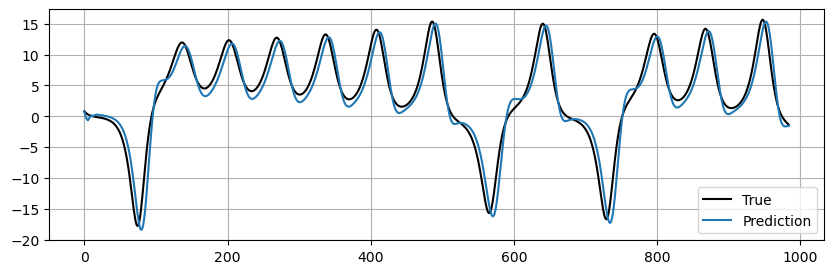

In [61]:
plt.figure(figsize=(10,3))
plt.plot(Yte[n_drop:,:], 'k', label='True')
plt.plot(scaler.inverse_transform(Yhat_pca), label='Prediction')
plt.legend()
plt.grid()
plt.show()

The fact that the readout can produce a good forecast means that the Reservoir captured the dynamics of the Lorenz system, i.e., that the Reservoir dynamics aligns to that of the Lorenz system.
If that happens, the evolution of its internal states should resemble the Lorenz attractor.

There are several measures that are used in non-linear time series analysis to verify the topological similarity between two attractors. See [here](https://nbviewer.org/github/FilippoMB/python-time-series-handbook/blob/main/notebooks/11/nonlinear-ts.ipynb) if you are interested in more details.
For the sake of this example, we limit ourselves to plotting the evolution of the Reservoir states.
Clearly, we notice that the trajectory of the Reservoir states closely resemble the Lorenz attractor, meaning that the Reservoir managed to copy the dynamics of the system.

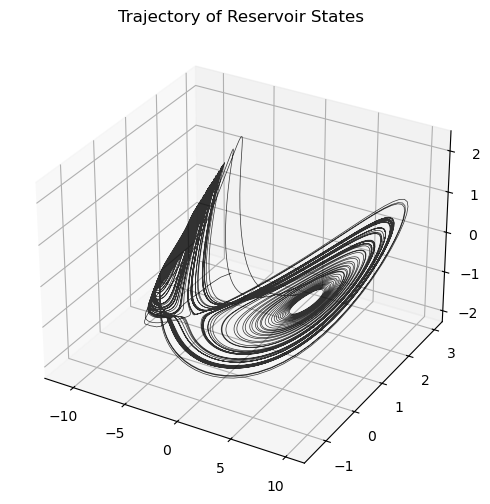

In [62]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*states_tr_pca.T, 'k', linewidth=0.5, alpha=.8)
ax.set_title("Trajectory of Reservoir States")
plt.show()